In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay
import warnings
warnings.filterwarnings("ignore")
import json

import keras
from keras import ops
from keras.models import Sequential, Model
from keras.layers import Input, Dense
from keras.metrics import Mean

import tensorflow as tf
import tensorflow_probability as tfp
import torch

import yfinance as yf
from tqdm import tqdm

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Colab Notebooks/Imperial MLDS/DeepTimeSeriesClustering'
os.chdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Config File

In [ ]:
params_filename = "params.json"
params_path = os.path.join(path, params_filename)

with open(params_path, 'r') as f:
  config = json.load(f)

# Define key dates
cut_off_date = config['cut_off_date']
data_start = config['data_start']
strat_start = config['strat_start']
strat_end = config['strat_end']
config

{'cut_off_date': '2025-06-01',
 'data_start': '2024-04-01',
 'strat_start': '2024-05-01',
 'strat_end': '2025-04-30',
 'latent_dim': 64,
 'num_heads': 16,
 'batch_size': 16,
 'pretrain_epochs': 20,
 'min_samples': 2,
 'max_clusters': 10,
 'gamma': {'mse': 1.0,
  'momentum_guided': 1.0,
  'cluster': 20.0,
  'momentum': 0.5,
  'acceleration': 0.5},
 'alpha': 0.1,
 'epochs': 100}

# Run Files

In [ ]:
%run "/content/drive/MyDrive/Colab Notebooks/Imperial MLDS/DeepTimeSeriesClustering/model.ipynb"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Input features: ['r_close', 'norm_log_volume', 'rsi', 'macd', 'signal']
Number of input features: 5
Number of tickers: 500
Number of time_steps: 249


Data shape: (500, 249, 5)
Number of batches: 32
Metadata shape: (500, 3)


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 249, 5)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 249, 64)   │     17,920 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 249, 64)   │     33,024 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 249, 64)   │     16,640 │ lstm_1[0][0],     │
│ (MultiHeadAttentio… │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 249, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 249, 64)   │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      4,160 │ get_item[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 71,872 (280.75 KB)

 Trainable params: 71,872 (280.75 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 249, 64)   │          0 │ input_layer_1[0]… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 249, 64)   │     33,024 │ repeat_vector[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 249, 64)   │     33,024 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 249, 64)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 249, 64)   │     16,640 │ lstm_3[0][0],     │
│ (MultiHeadAttentio… │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 249, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 249, 64)   │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 249, 5)    │        325 │ layer_normalizat… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 83,141 (324.77 KB)

 Trainable params: 83,141 (324.77 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
!pip install import-ipynb
!pip install nbimporter

import import_ipynb
import nbimporter
from eval import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Input features: ['r_close', 'norm_log_volume', 'rsi', 'macd', 'signal']
Number of input features: 5
Number of tickers: 500
Number of time_steps: 249


Data shape: (500, 249, 5)
Number of batches: 32
Metadata shape: (500, 3)


In [ ]:
curr_run = get_next_run_id()
print(f"Run {curr_run}")

Run 36


# Synthetic Data Evaluation

In [ ]:
%run "/content/drive/MyDrive/Colab Notebooks/Imperial MLDS/DeepTimeSeriesClustering/synthetic_data.ipynb"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Synthetic Dataset Statistics Before Scaling:


,r_close,norm_log_volume,rsi,macd,signal
count,124500.000000,124500.000000,124500.000000,124500.000000,124500.000000
mean,-0.000090,1.065411,49.890115,-0.037822,-0.034987
std,0.017839,0.341289,18.519019,8.355623,6.668105
min,-0.062449,0.500000,0.000000,-18.243392,-14.023563
25%,-0.014585,0.765268,36.359047,-8.677251,-7.021035
50%,-0.000078,0.999250,49.897734,-0.005778,-0.016678
75%,0.014301,1.431805,63.367279,8.625553,6.969039
max,0.057870,1.876016,100.000000,19.124229,13.673282


NaN Counts:


,0
r_close,0
norm_log_volume,0
rsi,0
macd,0
signal,0


Synthetic Dataset Statistics After Scaling:


,r_close,norm_log_volume,rsi,macd,signal
count,1.245000e+05,1.245000e+05,1.245000e+05,1.245000e+05,1.245000e+05
mean,-1.000809e-15,-1.459940e-14,-1.944273e-14,-7.761752e-15,-2.881893e-15
std,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00
min,-3.495645e+00,-1.656697e+00,-2.694004e+00,-2.178849e+00,-2.097842e+00
25%,-8.125659e-01,-8.794406e-01,-7.306608e-01,-1.033970e+00,-1.047685e+00
50%,6.312942e-04,-1.938542e-01,4.114074e-04,3.835098e-03,2.745833e-03
75%,8.067042e-01,1.073566e+00,7.277501e-01,1.036836e+00,1.050382e+00
max,3.248984e+00,2.375137e+00,2.705872e+00,2.293321e+00,2.055805e+00


NaN Counts After Scaling: 0


In [ ]:
config['encoder'] = encoder
config['decoder'] = decoder
config['callbacks'] = [
    ClusterCentroidUpdateCallback()
]
config['optimizer'] = tf.keras.optimizers.Adam(1e-4)
config['min_samples'] = 3
config['max_clusters'] = 3
config['alpha'] = 1.0
config['epochs'] = 20
config['pretrain_epochs'] = 10

In [ ]:
# Create synthetic dataset
synthetic_dataset = tf.data.Dataset.from_tensor_slices(data_tensor).batch(batch_size)

# Enable eager mode
tf.config.run_functions_eagerly(True)

## Full Loss

In [ ]:
config['gamma']['cluster'] = 1.0
config['gamma']['momentum_guided'] = 1.0
config['gamma']['momentum'] = 1.0
config['gamma']['acceleration'] = 1.0

In [ ]:
full_loss_config = config

syn_ari_full, syn_nim_full, syn_silh_full, syn_db_full, syn_encoded_full, syn_hist_full, syn_pred_full = synthetic_data_evaluation(
    run_id=curr_run,
    num_runs=5,
    params=full_loss_config,
    model=DeepMomentumClustering,
    synthetic_dataset=synthetic_dataset,
    synthetic_data_tensor=synthetic_data_tensor,
    ground_truth_labels=ground_truth_labels
)

Running Run 1
Run 1 results: ARI = 0.9819, NMI = 0.9662, Silhouette Score = 0.5852, DBI = 0.7200

Running Run 2
Run 2 results: ARI = 0.9880, NMI = 0.9791, Silhouette Score = 0.5501, DBI = 0.7406

Running Run 3
Run 3 results: ARI = 0.9761, NMI = 0.9595, Silhouette Score = 0.5942, DBI = 0.6553

Running Run 4
Run 4 results: ARI = 0.9941, NMI = 0.9902, Silhouette Score = 0.6269, DBI = 0.5681

Running Run 5
Run 5 results: ARI = 0.9361, NMI = 0.9134, Silhouette Score = 0.5146, DBI = 0.6621

Mean ARI: 0.9752 +/- 0.0204
Mean NMI: 0.9617 +/- 0.0264
Mean Silhouette: 0.5742 +/- 0.0386
Mean DB: 0.6692 +/- 0.0603


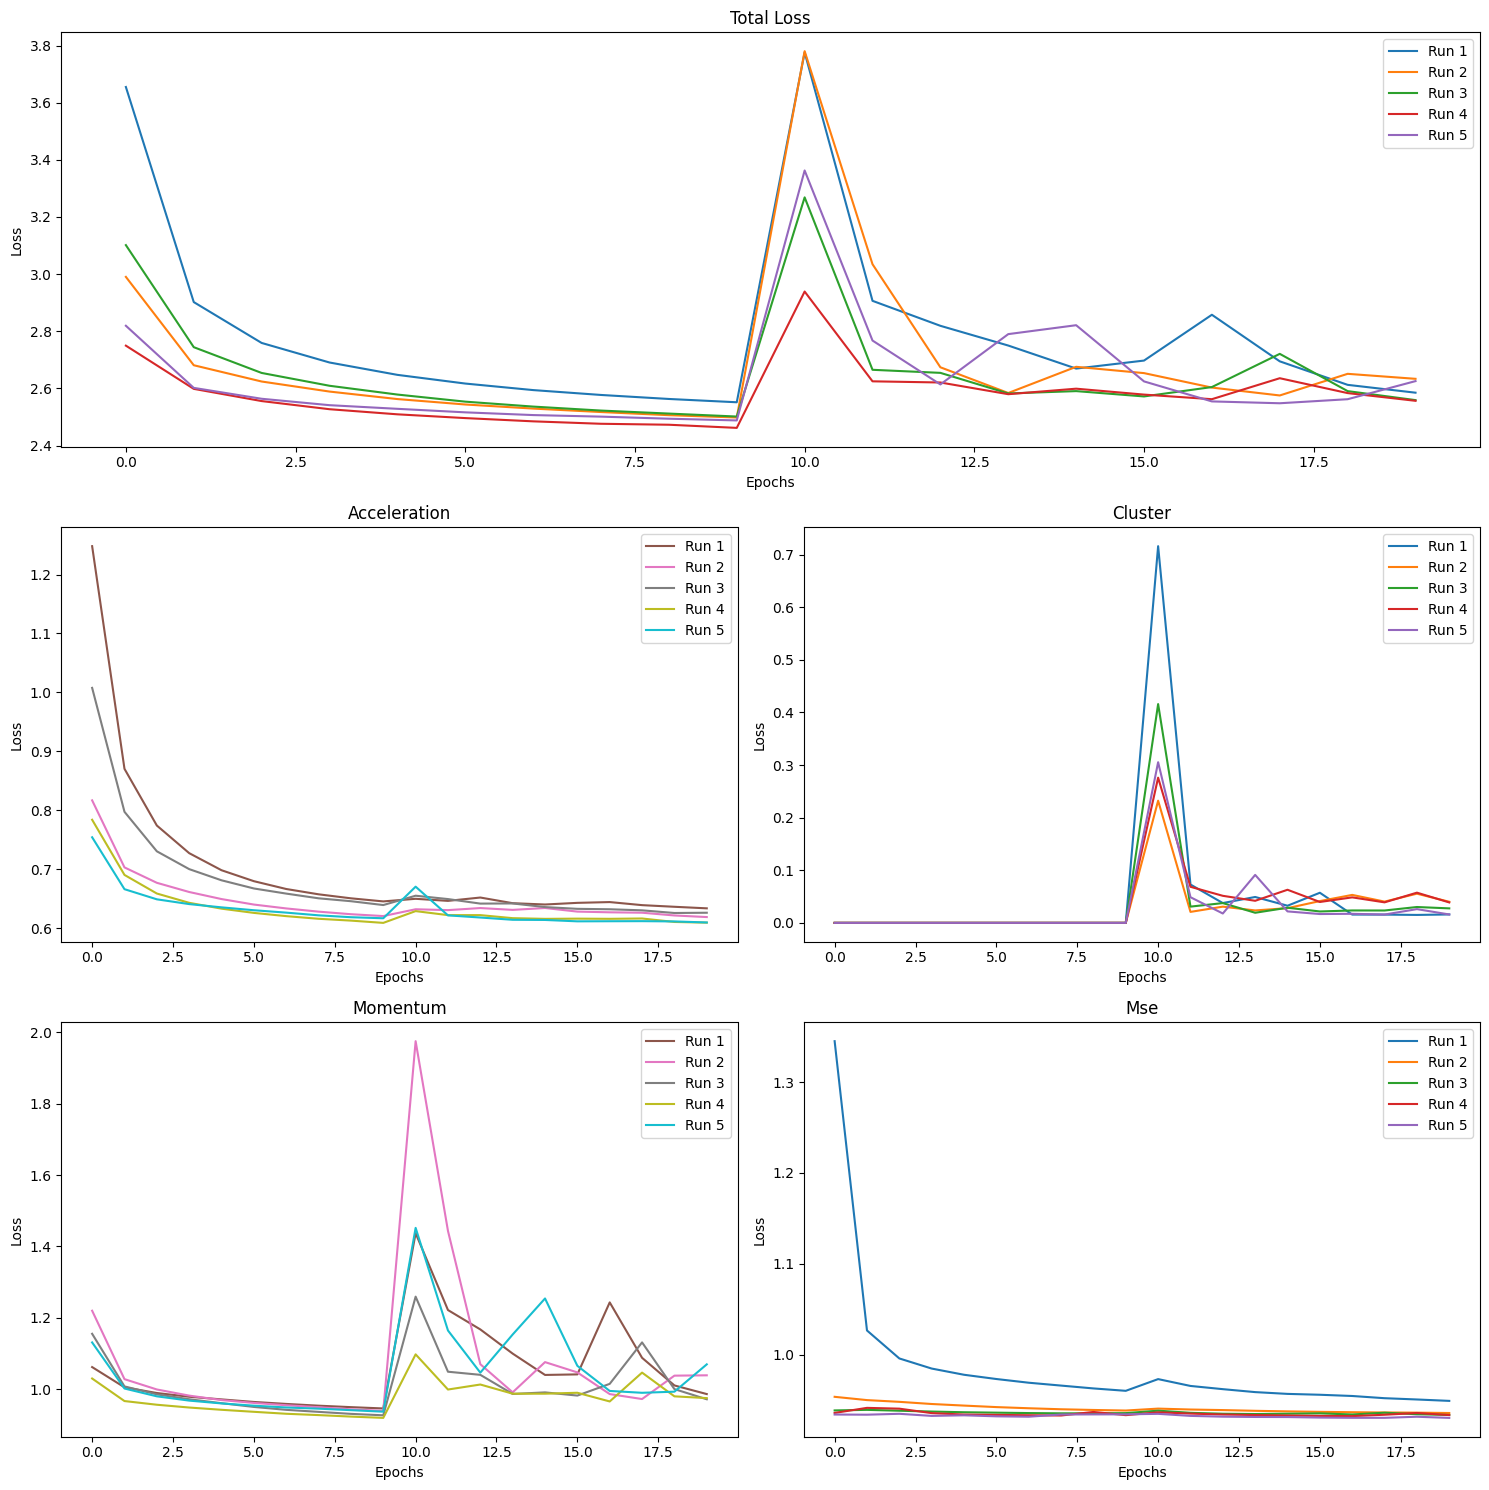

In [ ]:
plot_loss(curr_run, syn_hist_full, list(syn_hist_full[0].history.keys()), filename=f"synthetic_full_loss.png")

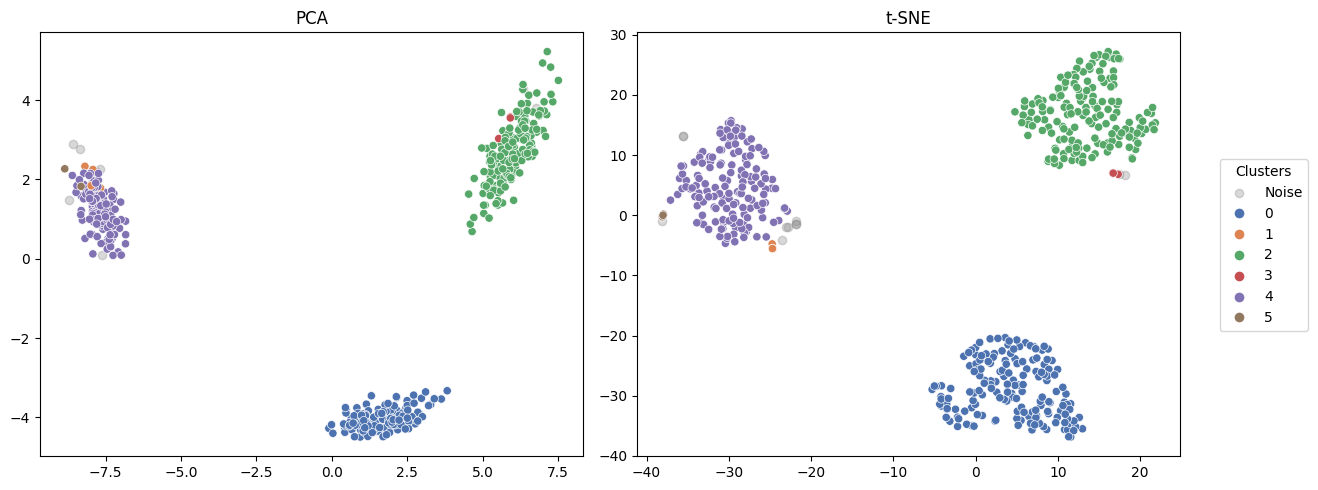

In [ ]:
plot_pca_tsne(curr_run, syn_encoded_full[-1], syn_pred_full[-1], filename=f"synthetic_full_pca_tsne.png")

## Without Momentum Guided Loss

In [ ]:
config['gamma']['cluster'] = 1.0
config['gamma']['momentum_guided'] = 0.0
config['gamma']['momentum'] = 1.0
config['gamma']['acceleration'] = 1.0

In [ ]:
no_momentum_guided_config = config

syn_ari_partial_1, syn_nim_partial_1, syn_silh_partial_1, syn_db_partial_1, syn_encoded_partial_1, syn_hist_partial_1, syn_pred_partial_1 = synthetic_data_evaluation(
    run_id=curr_run,
    num_runs=5,
    params=no_momentum_guided_config,
    model=DeepMomentumClustering,
    synthetic_dataset=synthetic_dataset,
    synthetic_data_tensor=synthetic_data_tensor,
    ground_truth_labels=ground_truth_labels
)

Running Run 1
Run 1 results: ARI = 0.9728, NMI = 0.9541, Silhouette Score = 0.5332, DBI = 0.6927

Running Run 2
Run 2 results: ARI = 0.9230, NMI = 0.9001, Silhouette Score = 0.5267, DBI = 0.6717

Running Run 3
Run 3 results: ARI = 0.9229, NMI = 0.9007, Silhouette Score = 0.5922, DBI = 0.6065

Running Run 4
Run 4 results: ARI = 0.9879, NMI = 0.9756, Silhouette Score = 0.6373, DBI = 0.5033

Running Run 5
Run 5 results: ARI = 0.9373, NMI = 0.9206, Silhouette Score = 0.5257, DBI = 0.6655

Mean ARI: 0.9488 +/- 0.0267
Mean NMI: 0.9302 +/- 0.0300
Mean Silhouette: 0.5630 +/- 0.0446
Mean DB: 0.6279 +/- 0.0686


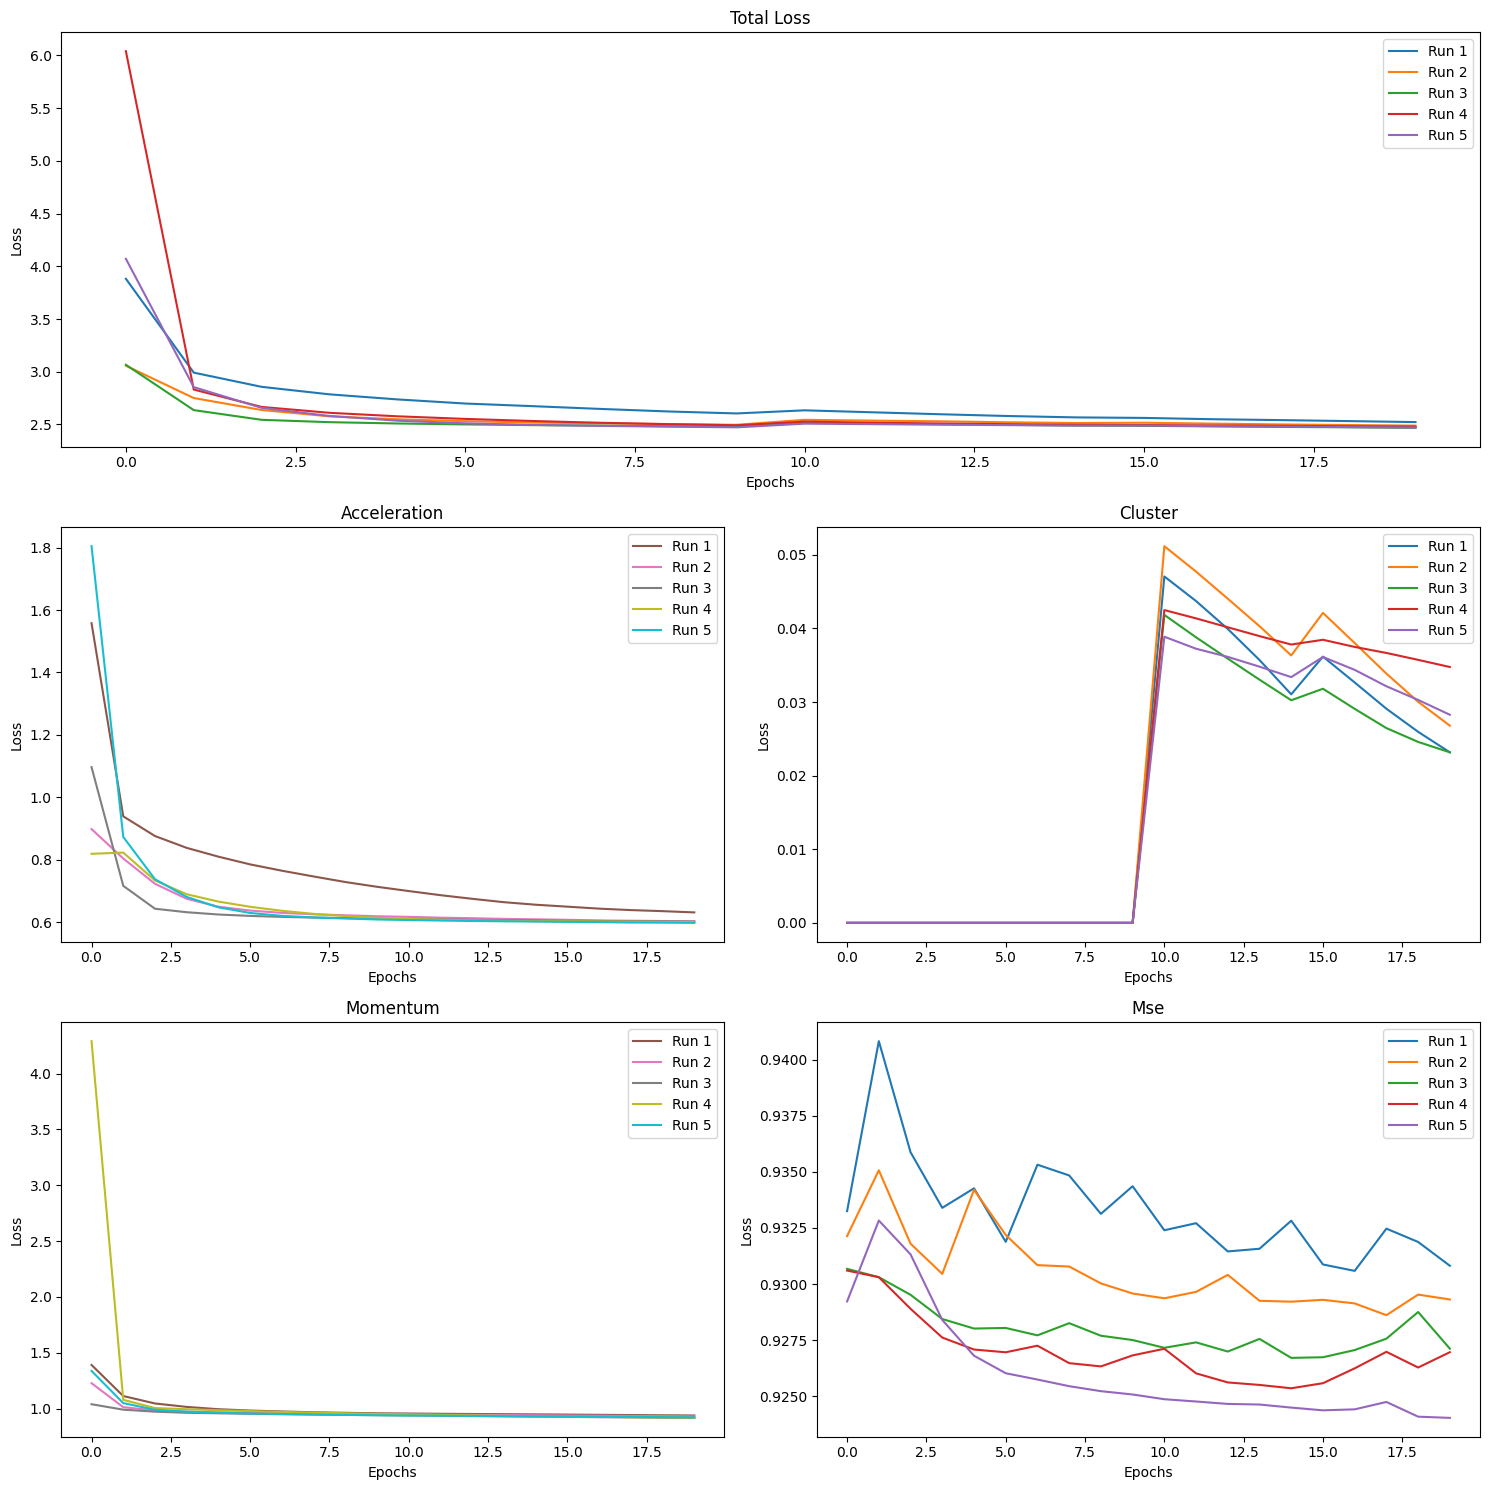

In [ ]:
plot_loss(curr_run, syn_hist_partial_1, list(syn_hist_partial_1[0].history.keys()), filename=f"synthetic_without_momentum_guided_loss.png")

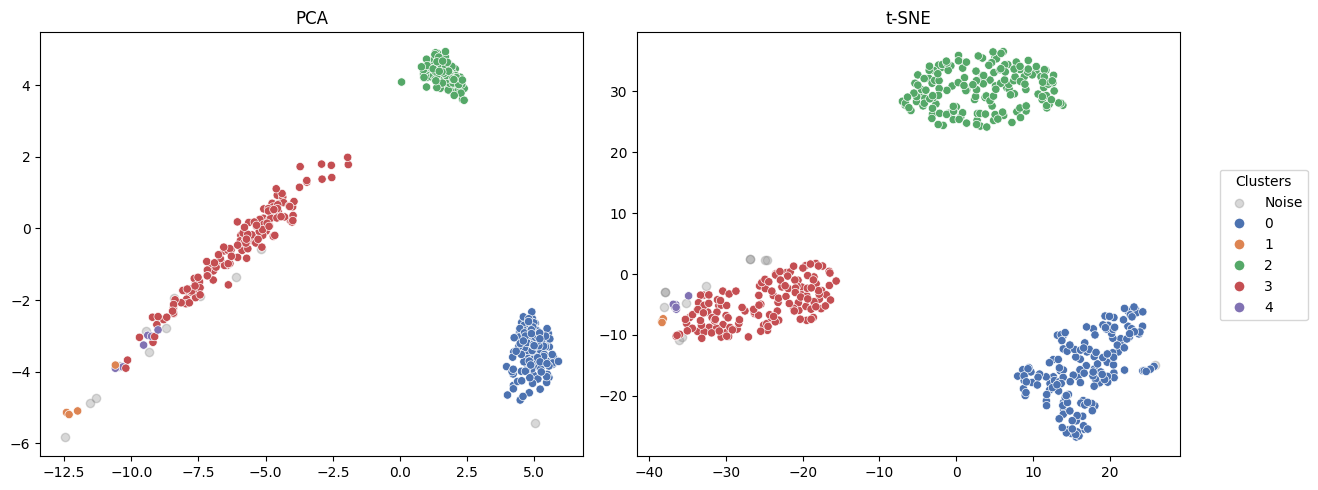

In [ ]:
plot_pca_tsne(curr_run, syn_encoded_partial_1[-1], syn_pred_partial_1[-1], filename=f"synthetic_without_momentum_guided_pca_tsne.png")

## Without Momentum and Acceleration Losses

In [ ]:
config['gamma']['cluster'] = 1.0
config['gamma']['momentum_guided'] = 1.0
config['gamma']['momentum'] = 0.0
config['gamma']['acceleration'] = 0.0

In [ ]:
no_momentum_acceleration_config = config

syn_ari_partial_2, syn_nim_partial_2, syn_silh_partial_2, syn_db_partial_2, syn_encoded_partial_2, syn_hist_partial_2, syn_pred_partial_2 = synthetic_data_evaluation(
    run_id=curr_run,
    num_runs=5,
    params=no_momentum_acceleration_config,
    model=DeepMomentumClustering,
    synthetic_dataset=synthetic_dataset,
    synthetic_data_tensor=synthetic_data_tensor,
    ground_truth_labels=ground_truth_labels
)

Running Run 1
Run 1 results: ARI = 0.9342, NMI = 0.9186, Silhouette Score = 0.5941, DBI = 0.5642

Running Run 2
Run 2 results: ARI = 0.9792, NMI = 0.9643, Silhouette Score = 0.6368, DBI = 0.5375

Running Run 3
Run 3 results: ARI = 0.9251, NMI = 0.9091, Silhouette Score = 0.5680, DBI = 0.5720

Running Run 4
Run 4 results: ARI = 0.9970, NMI = 0.9945, Silhouette Score = 0.6086, DBI = 0.5530

Running Run 5
Run 5 results: ARI = 0.9706, NMI = 0.9536, Silhouette Score = 0.6000, DBI = 0.5964

Mean ARI: 0.9612 +/- 0.0273
Mean NMI: 0.9480 +/- 0.0311
Mean Silhouette: 0.6015 +/- 0.0223
Mean DB: 0.5646 +/- 0.0197


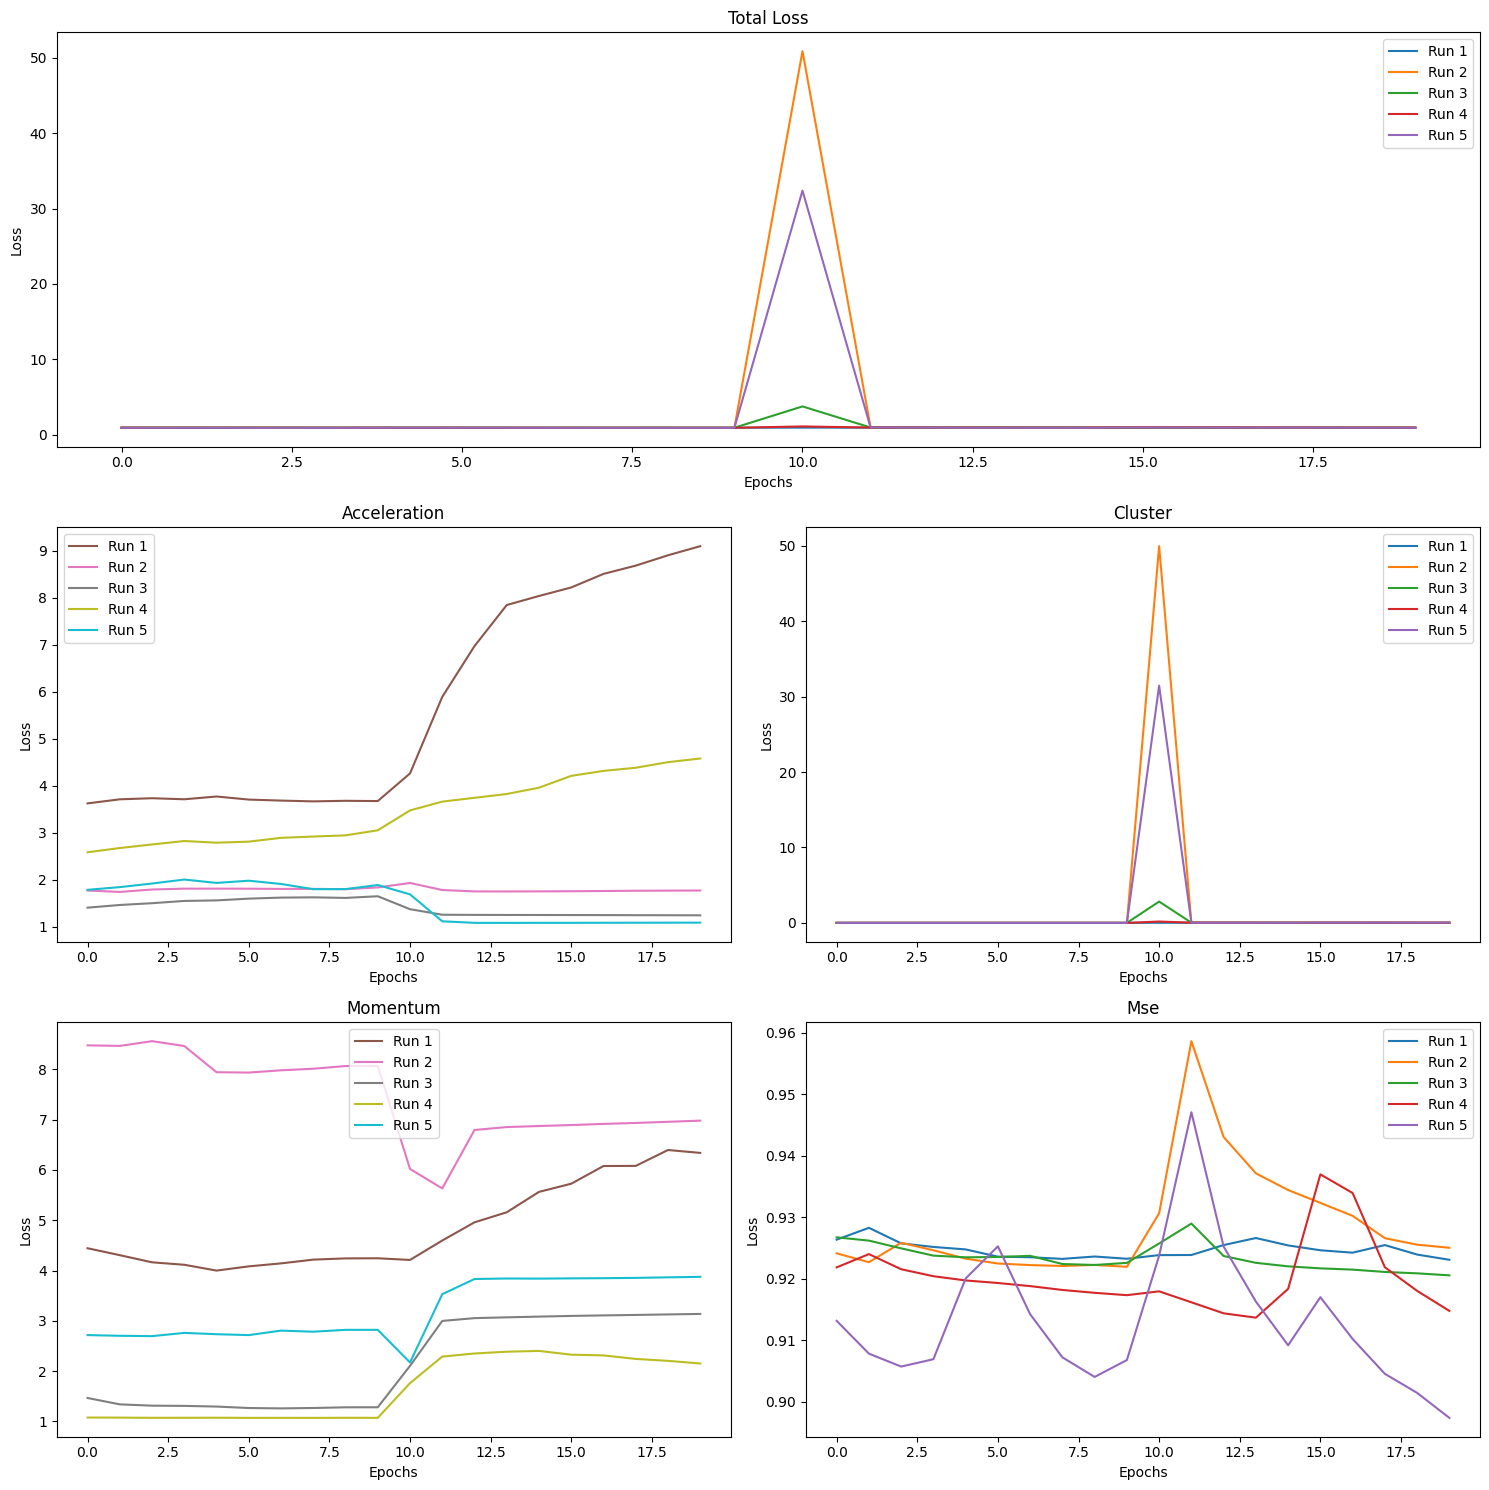

In [ ]:
plot_loss(curr_run, syn_hist_partial_2, list(syn_hist_partial_2[0].history.keys()), filename=f"synthetic_without_momentum_acceleration_loss.png")

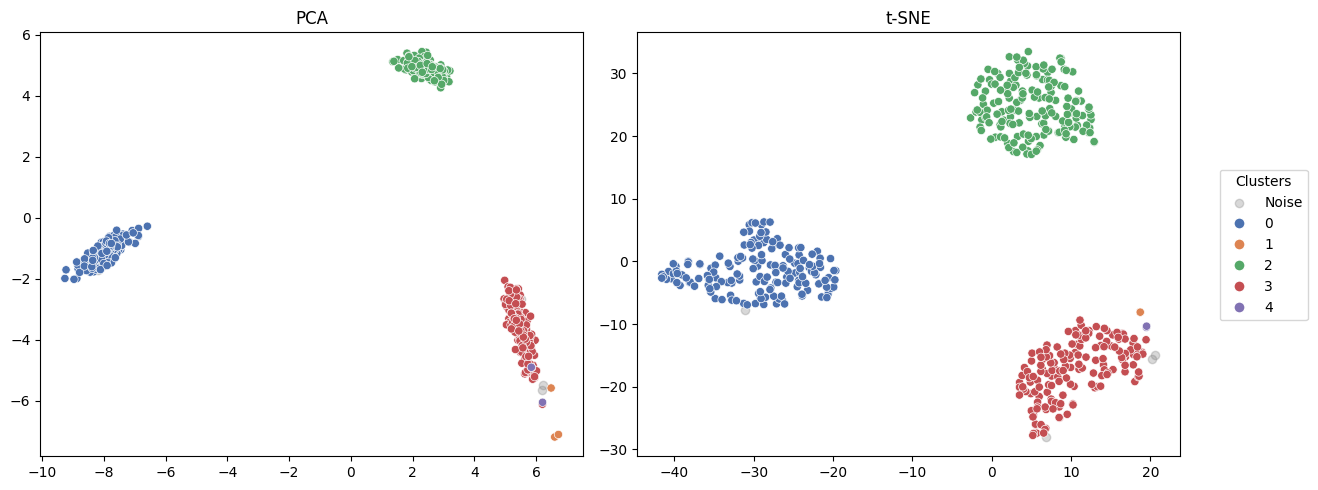

In [ ]:
plot_pca_tsne(curr_run, syn_encoded_partial_2[-1], syn_pred_partial_2[-1], filename=f"synthetic_without_momentum_acceleration_pca_tsne.png")

# Parameter Tuning

In [ ]:
config['encoder'] = encoder
config['decoder'] = decoder
config['callbacks'] = [
    ClusterCentroidUpdateCallback(),
    keras.callbacks.ReduceLROnPlateau(
        monitor='loss',
        factor=0.5,
        patience=10,
        min_lr=1e-6
    )
]
config['optimizer'] = tf.keras.optimizers.Adam(1e-4)
config['num_heads'] = 32
config['min_samples'] = 7
config['max_clusters'] = 5
config['alpha'] = 0.65
config['gamma']['cluster'] = 1.5
config['gamma']['momentum'] = 1.3
config['gamma']['momentum_guided'] = 0.75
config['gamma']['acceleration'] = 1.2
config['epochs'] = 200
config['pretrain_epochs'] = 75

# Real-World Data Evaluation

In [ ]:
# Disable eager mode
tf.config.run_functions_eagerly(False)

In [ ]:
config

{'cut_off_date': '2025-06-01',
 'data_start': '2024-04-01',
 'strat_start': '2024-05-01',
 'strat_end': '2025-04-30',
 'latent_dim': 64,
 'num_heads': 32,
 'batch_size': 16,
 'pretrain_epochs': 75,
 'min_samples': 7,
 'max_clusters': 5,
 'gamma': {'mse': 1.0,
  'momentum_guided': 0.75,
  'cluster': 1.5,
  'momentum': 1.3,
  'acceleration': 1.2},
 'alpha': 0.65,
 'epochs': 200,
 'encoder': <Functional name=encoder, built=True>,
 'decoder': <Functional name=decoder, built=True>,
 'callbacks': [<__main__.ClusterCentroidUpdateCallback at 0x7f70b50d6c30>,
 'optimizer': <keras.src.optimizers.adam.Adam at 0x7f71006a9a00>}

In [ ]:
dmc = DeepMomentumClustering(
    dataset=dataset,
    encoder=config["encoder"],
    decoder=config["decoder"],
    latent_dim=config["latent_dim"],
    pretrain_epochs=config["pretrain_epochs"],
    min_samples=config["min_samples"],
    max_clusters=config["max_clusters"],
    gamma=config["gamma"],
    alpha=config["alpha"],
    verbose=1
)

dmc.compile(optimizer=config['optimizer'])

history = dmc.fit(dataset, epochs=config['epochs'], verbose=2, callbacks=[config['callbacks']])

Epoch 1/200
32/32 - 21s - 646ms/step - acceleration: 1.3144 - cluster: 0.0000e+00 - loss: 7.7651 - momentum: 4.0637 - mse: 0.9050 - learning_rate: 1.0000e-04
Epoch 2/200
32/32 - 3s - 93ms/step - acceleration: 0.9500 - cluster: 0.0000e+00 - loss: 3.4397 - momentum: 1.0725 - mse: 0.9054 - learning_rate: 1.0000e-04
Epoch 3/200
32/32 - 3s - 96ms/step - acceleration: 0.8463 - cluster: 0.0000e+00 - loss: 3.2204 - momentum: 1.0109 - mse: 0.8907 - learning_rate: 1.0000e-04
Epoch 4/200
32/32 - 5s - 160ms/step - acceleration: 0.7834 - cluster: 0.0000e+00 - loss: 3.1382 - momentum: 0.9893 - mse: 0.9121 - learning_rate: 1.0000e-04
Epoch 5/200
32/32 - 3s - 94ms/step - acceleration: 0.7403 - cluster: 0.0000e+00 - loss: 3.0792 - momentum: 0.9780 - mse: 0.9195 - learning_rate: 1.0000e-04
Epoch 6/200
32/32 - 3s - 95ms/step - acceleration: 0.7081 - cluster: 0.0000e+00 - loss: 3.0053 - momentum: 0.9684 - mse: 0.8966 - learning_rate: 1.0000e-04
Epoch 7/200
32/32 - 3s - 94ms/step - acceleration: 0.6857 - c

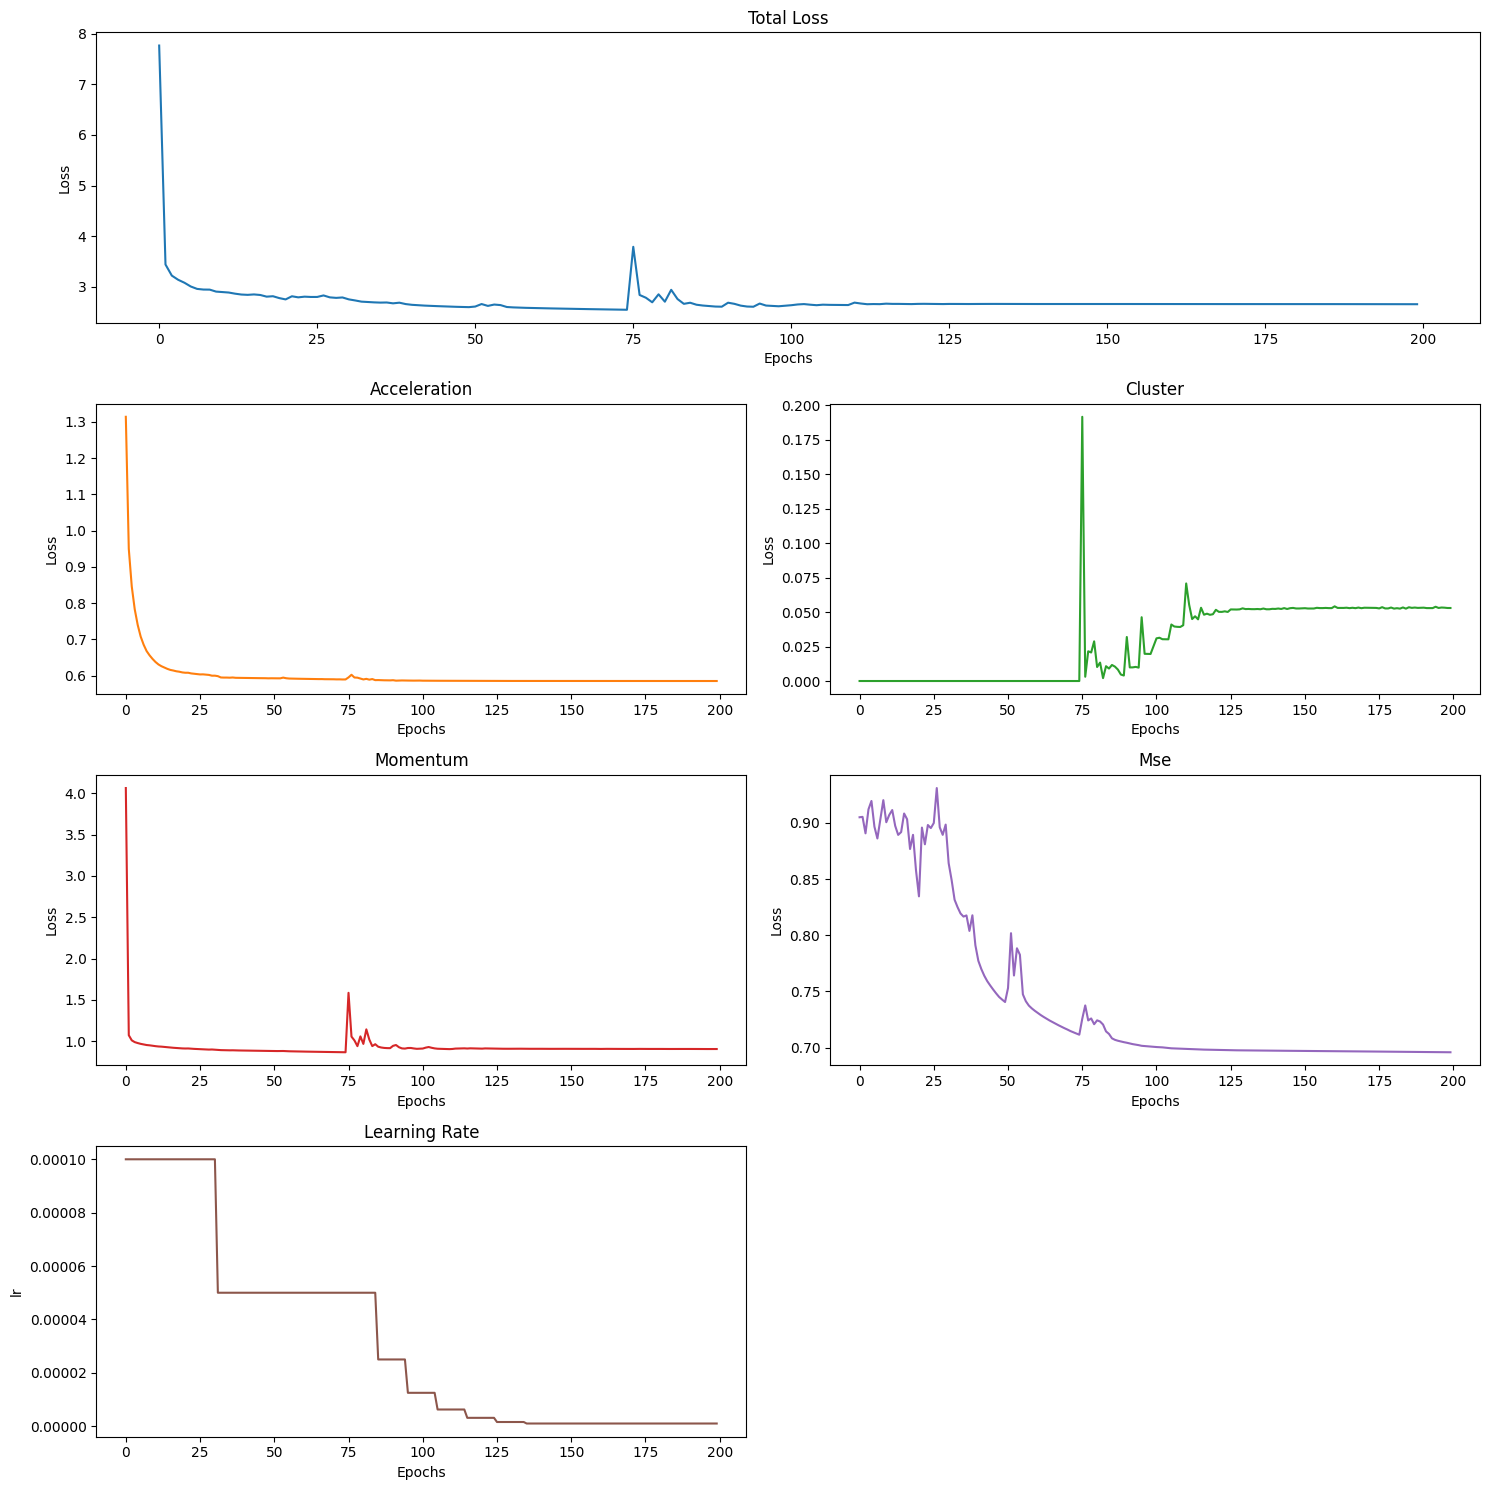

In [ ]:
plot_loss(curr_run, [history], list(history.history.keys()))

In [ ]:
# Encode data into latent representation and predict labels
encoded_real_data = dmc.encoder(data_tensor)[0].numpy()
hdbscan = HDBSCAN(min_cluster_size=dmc.min_samples, min_samples=dmc.min_samples, cluster_selection_method='eom')
in_sample_cluster_labels = hdbscan.fit_predict(encoded_real_data)
real_data_metadata['Cluster'] = in_sample_cluster_labels

# Compute momentum score for each cluster
in_sample_momentum = compute_momentum_scores(data_tensor)
real_data_metadata['Momentum'] = in_sample_momentum

In [ ]:
# Evaluate cluster's momentum
num_clusters, high_momentum_cluster, high_momentum_tickers, high_momentum_cluster_mean_momentum, high_momentum_cluster_momentum_std = in_sample_evaluation(
    start_date=config['strat_start'],
    end_date=config['strat_end'],
    metadata=real_data_metadata
    )

High-momentum cluster: 1
Stocks in high-momentum cluster: ['AEP' 'AFL' 'BR' 'DUK' 'ETR' 'EVRG' 'SO' 'VTR' 'WEC' 'WMB']

In-Sample Momentum Statistics (2024-05-01 to 2025-04-30):


,Cluster,Momentum
1,0,-0.025279
2,1,0.040517



In-Sample Momentum Statistics For Noise Group (2024-05-01 to 2025-04-30):


,Cluster,Momentum
0,-1,0.013876


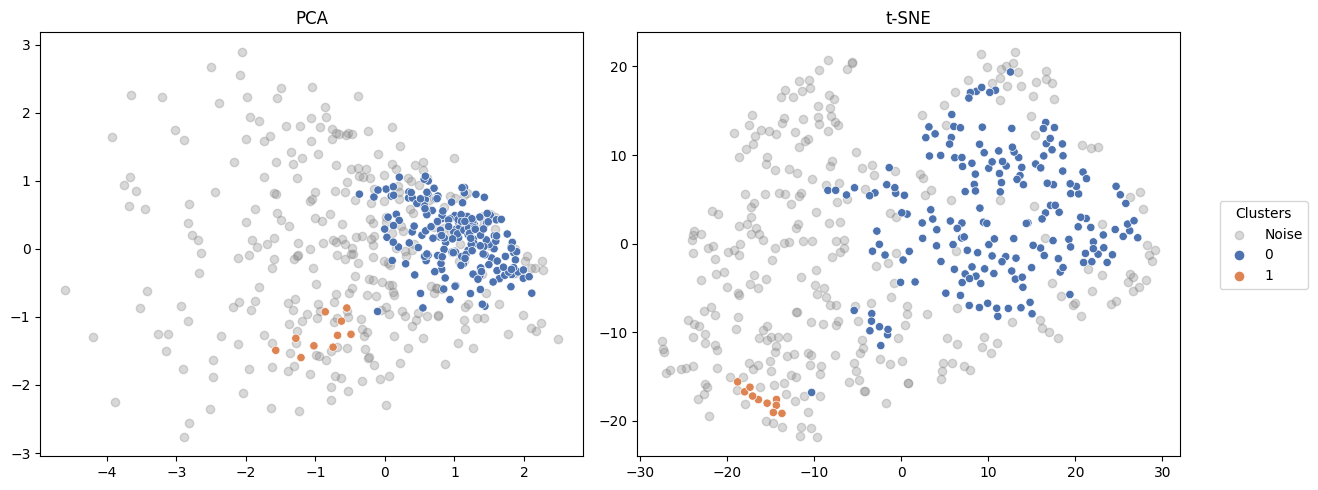

In [ ]:
# Plot PCA and t-SNE on sample data
plot_pca_tsne(curr_run,encoded_real_data, in_sample_cluster_labels)

In [ ]:
silh_score, db_score = external_clustering_metrics(encoded_real_data, real_data_metadata, in_sample_cluster_labels)

Silhouette Score: 0.4450
Davies-Bouldin Score: 0.6792



Momentum Statistics by Cluster:


,Cluster,mean,std,count
0,-1,0.013876,0.542512,306
1,0,-0.025279,0.615274,184
2,1,0.040517,0.020883,10


Kruskal-Wallis p-value: 0.8805


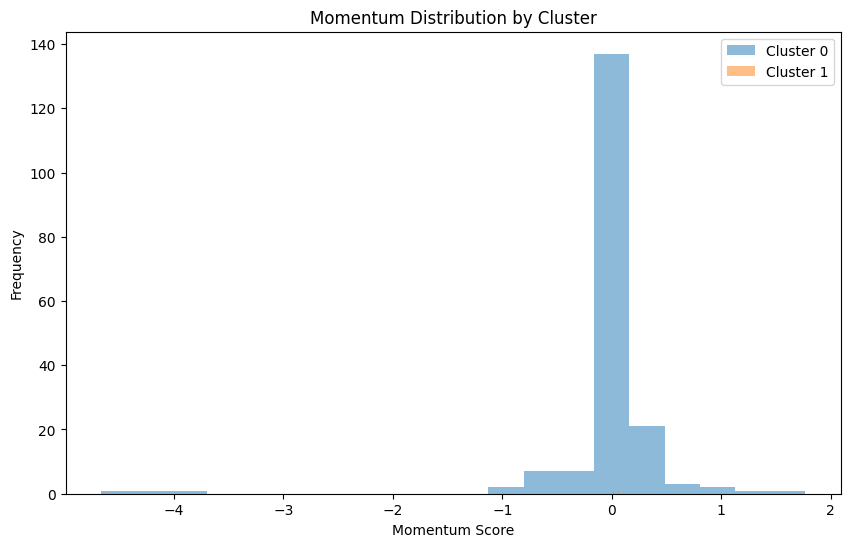

In [ ]:
kruskal = momentum_distribution(curr_run, real_data_metadata, in_sample_cluster_labels)

In [ ]:
# Create out-of-sample dataframe for evaluation
def create_out_sample_df(start_date, end_date, metadata):
  out_sample_data = pd.DataFrame({"Ticker": metadata['Ticker'].unique(), "Start": len(metadata['Ticker'].unique()) * [start_date], "End": len(metadata['Ticker'].unique()) * [end_date]})
  out_sample_df = pd.concat(out_sample_data.apply(lambda df: get_price(df['Ticker'], df['Start'], df['End']), axis=1).tolist())
  return out_sample_df

In [ ]:
# Retrieve out-of-sample pricing data
in_sample_df = snp500_hist_transformed[['Ticker', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume']].copy()

out_sample_start = "2025-07-01"
out_sample_end = "2025-08-01"
out_sample_filename = f'out_sample_{config['cut_off_date'].replace("-", "")}_{out_sample_end.replace("-", "")}.csv'
out_sample_path = os.path.join(path, out_sample_filename)

if not os.path.isfile(out_sample_path):
  print("Downloading data...\n")
  out_sample_df = create_out_sample_df(config['cut_off_date'], out_sample_end, real_data_metadata)
  out_sample_df.to_csv(out_sample_path, index=False)
  print(f"Exported as {out_sample_filename}")
else:
  out_sample_df = pd.read_csv(out_sample_path, encoding='utf-8')


Out-of-Sample Cluster Performance (2025-07-01 - 2025-08-01):


,Cluster,Cumulative Return,Volatility,Sharpe Ratio,Momentum,Tickers
0,0,0.007115,0.128852,0.055174,1.930823e-17,"[A, AAPL, ABNB, ACN, ADI, ADSK, AKAM, ALB, AMA..."
1,1,0.031244,0.120148,0.259828,-2.220446e-17,"[AEP, AFL, BR, DUK, ETR, EVRG, SO, VTR, WEC, WMB]"



High-Momentum Cluster (Cluster 1) Outperformance:
	Cumulative Return vs. S&P 500: 0.0081

High-Momentum Cluster Performance (2025-07-01 - 2025-08-01):
	Cumulative Return: 0.0312
	Volatility: 0.1201
	Sharpe Ratio: 0.2598

S&P 500 Performance (2025-07-01 - 2025-08-01):
	Cumulative Return: 0.0232
	Volatility: 0.0670
	Sharpe Ratio: 0.3455

Momentum Comparison:


,Cluster,In-Sample Momentum,Out-of-Sample Momentum
0,0,-0.025279,1.930823e-17
1,1,0.040517,-2.220446e-17


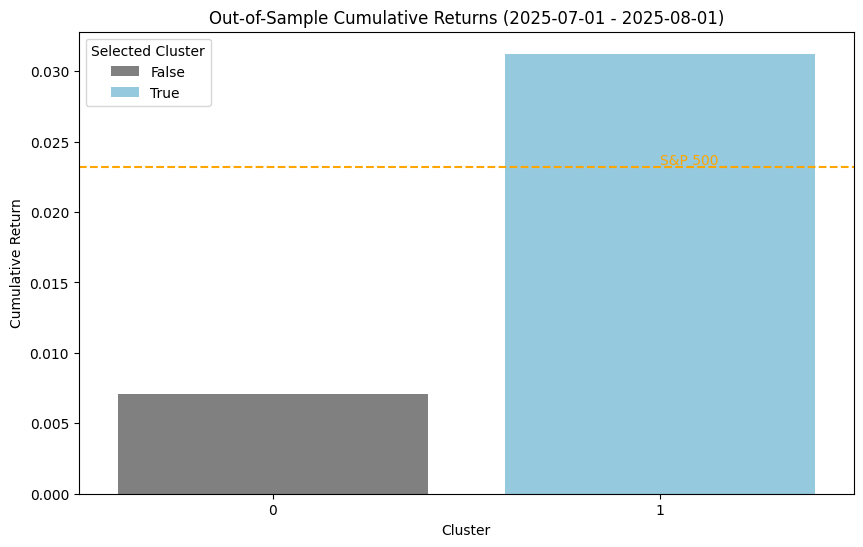

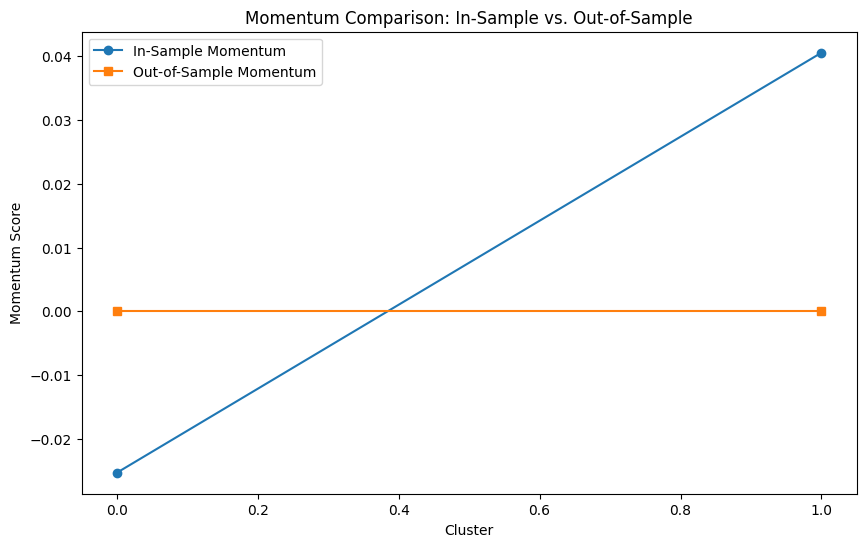

In [ ]:
# Evaluate high-momentum cluster's performance on out-of-sample data
cluster_cum_return, cluster_volatility, cluster_sharpe, snp500_cum_return, snp500_volatility, snp500_sharpe, outperformance = out_sample_evaluation(
    curr_run,
    in_sample_df,
    out_sample_df,
    config['data_start'],
    config['strat_start'],
    out_sample_start,
    out_sample_end,
    real_data_metadata,
    high_momentum_cluster
)

In [ ]:
# Save current run's log
save_run(curr_run,
         num_clusters,
         high_momentum_cluster,
         high_momentum_tickers,
         silh_score,
         db_score,
         kruskal,
         high_momentum_cluster_mean_momentum,
         high_momentum_cluster_momentum_std,
         cluster_cum_return,
         cluster_volatility,
         cluster_sharpe,
         outperformance,
         config['strat_start'],
         config['strat_end'],
         out_sample_start,
         out_sample_end,
         snp500_cum_return,
         snp500_volatility,
         snp500_sharpe)

In [ ]:
# Save current run's environment
save_environment(curr_run, dmc, history.history, config)